In [51]:
from astropy.io import fits
import numpy as np
from astropy.table import Table
import sys
sys.path.append('/Users/rociokiman/Documents/Gaia-Cupid/ActivityAgeRelation/banyan_sigma')
from banyan_sigma import banyan_sigma
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord  # High-level coordinates
import astropy.units as u
import random
%config InlineBackend.figure_format = 'retina'

In [52]:
mg_literature = Table.read('Catalogs/mactivity_movinggroups_gaia.fits')

In [53]:
mg_ref = Table.read('Catalogs/moving_groups_ref.csv',format='csv')
source_ref_table = Table.read('Catalogs/source_ref.csv',format='csv')

In [54]:
len(mg_literature)

71907

# Defining mask to clean the sample

### Distinguish accreation from chromospheric emission

In [4]:
def spt_to_g_rp(spt):
    """
    Relation from Kiman et al. 2019
    """
    return -0.0036*spt**2 + 0.11*spt + 0.89

def def_mask_acc(color,ewha):
    """
    White, R. J. & Basri, G. 
    VERY LOW MASS STARS AND BROWN DWARFS IN TAURUS-AURIGA. 
    Astrophys. J. 582, 1109–1122 (2003).
    """
    if(color<spt_to_g_rp(2.7)):
        return ewha < 10
    elif(color<spt_to_g_rp(5.7)):
        return ewha < 20
    elif(color>=spt_to_g_rp(5.7)):
        return ewha < 40
    else:
        return False

In [5]:
mask_acc = []
for x,y in zip(mg_literature['phot_g_mean_mag']-mg_literature['phot_rp_mean_mag'],mg_literature['ewha']):
    mask_acc.append(def_mask_acc(x,y))
mask_acc = np.array(mask_acc)

### Mask absorption and signal to noise

In [6]:
mask_abs = mg_literature['ewha'] > 0

mask_snr_ha = mg_literature['ewha']/mg_literature['ewha_error'] > 2

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


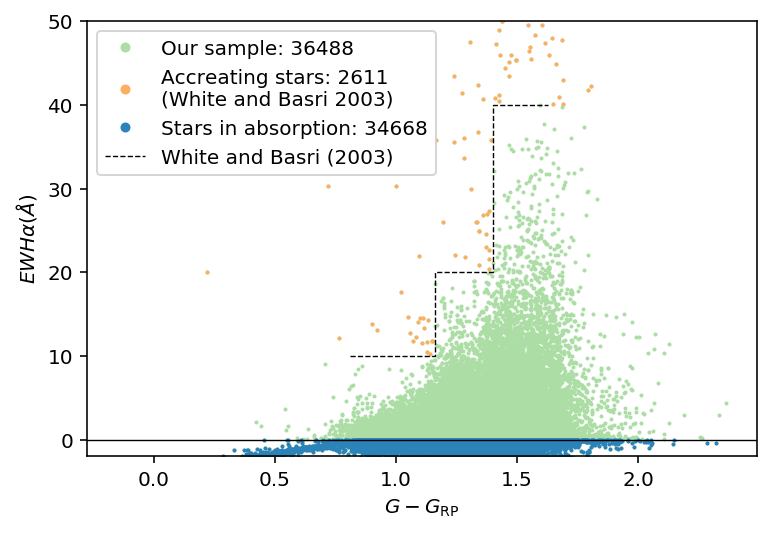

In [7]:
N = 10
linewidth = 0.7
x1 = np.linspace(spt_to_g_rp(-.7),spt_to_g_rp(2.7),N)
y1 = np.ones(N)*10
x2 = np.linspace(spt_to_g_rp(2.7),spt_to_g_rp(5.7),N)
y2 = np.ones(N)*20
x3 = np.linspace(spt_to_g_rp(5.7),spt_to_g_rp(10),N)
y3 = np.ones(N)*40
plt.plot(mg_literature['phot_g_mean_mag']-mg_literature['phot_rp_mean_mag'],mg_literature['ewha'],
         '.',markersize=2,color='#abdda4',label='Our sample: {}'.format(len(mg_literature['phot_rp_mean_mag'][mask_acc*mask_abs])))
plt.plot(mg_literature['phot_g_mean_mag'][~mask_acc]-mg_literature['phot_rp_mean_mag'][~mask_acc],mg_literature['ewha'][~mask_acc],
         '.',markersize=2,label='Accreating stars: {}\n(White and Basri 2003)'.format(len(mg_literature['phot_rp_mean_mag'][~mask_acc]))
         ,color='#fdae61')
plt.plot(mg_literature['phot_g_mean_mag'][~mask_abs]-mg_literature['phot_rp_mean_mag'][~mask_abs],mg_literature['ewha'][~mask_abs],
         '.',markersize=2,label='Stars in absorption: {}'.format(len(mg_literature['phot_g_mean_mag'][~mask_abs])),
         color='#2b83ba')
plt.plot(np.concatenate((x1,x2,x3)),np.concatenate((y1,y2,y3)),'--k',linewidth=linewidth,
         label='White and Basri (2003)')
plt.axhline(y=0,color='k',linewidth=linewidth)
plt.ylim(-2,50)
plt.legend(markerscale=4)
plt.xlabel(r'$G-G_{\rm RP}$')
plt.ylabel(r'$EWH\alpha (\AA)$')
plt.savefig('Figures/limits_halpha.png',dpi=300)

### Checking compatibility with Kiman 2019

In [8]:
mg_mlsdss = fits.open('Catalogs/mactivity_movinggroups_mlsdss_5arcsec.fits')

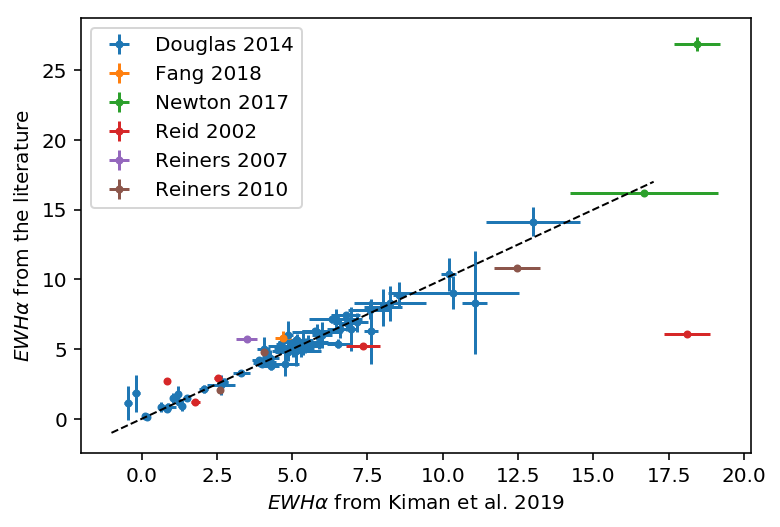

In [9]:
mask_ha_nan = ~np.isnan(mg_mlsdss[1].data['EWHA_2']) #If Halpha is nan I cannot actually check if they are compatible
compatible_groups = []
for i in range(len(source_ref_table['source_num'])):
    x = source_ref_table['source_num'][i]
    if(x!=source_ref_table['source_num'][source_ref_table['source_ref']=='Kiman 2019'][0]): #Kiman 2019 is compatible
        if(x in mg_mlsdss[1].data['source_num'][mask_ha_nan]):                              # with Kiman 2019 
            compatible_groups.append(x)
            mask_group_x = mg_mlsdss[1].data['source_num'] == x
            plt.errorbar(mg_mlsdss[1].data['EWHA_2'][mask_group_x],mg_mlsdss[1].data['ewha_1'][mask_group_x],
                         yerr = mg_mlsdss[1].data['ewha_error'][mask_group_x], 
                         xerr = mg_mlsdss[1].data['EWHA_ERR'][mask_group_x],
                         label=source_ref_table['source_ref'][i],fmt='.',zorder=0)
x = np.linspace(-1,17,10)
plt.plot(x,x,'--k',linewidth=1,zorder=2)
plt.xlabel(r'$EWH\alpha$ from Kiman et al. 2019')
plt.ylabel(r'$EWH\alpha$ from the literature')
plt.legend()
plt.savefig('Figures/CompatibleStars.png',dpi=300)
plt.show()

#Add Kiman 2019 after doing the plot
compatible_groups.append(source_ref_table['source_num'][source_ref_table['source_ref']=='Kiman 2019'][0])
#Change to array
compatible_groups = np.array(np.sort(compatible_groups))

In [10]:
mask_compatible = np.array([x in compatible_groups for x in mg_literature['source_num']])

# Running Banyan on literature sample of stars

In [11]:
ra = np.array([float(x) for x in mg_literature['ra_x']])
ra_err = np.array([float(x) for x in mg_literature['ra_error']])
dec = np.array([float(x) for x in mg_literature['dec_x']])
pmra = np.array([float(x) for x in mg_literature['pmra']])
pmra_error = np.array([float(x) for x in mg_literature['pmra_error']])
pmdec = np.array([float(x) for x in mg_literature['pmdec']])
pmdec_error = np.array([float(x) for x in mg_literature['pmdec_error']])
parallax = np.array([float(x) for x in mg_literature['parallax']])
parallax_error = np.array([float(x) for x in mg_literature['parallax_error']])
rv = np.array([float(x) for x in mg_literature['radial_velocity']])
rv_error = np.array([float(x) for x in mg_literature['radial_velocity_error']])

In [12]:
len(ra)

71907

In [13]:
mask_run_banyan = (~np.isnan(ra+dec+pmra+pmra_error+pmdec+pmdec_error+parallax+parallax_error)
                   * (parallax/parallax_error > 8)
                   * mask_acc)

#mask_compiled_literature2 = (~np.isnan(ra+dec+pmra+pmra_error+pmdec+pmdec_error+parallax+parallax_error) 
#                            * (parallax/parallax_error > 8)
#                            * mask_abs
#                            * mask_acc)

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
len(ra[mask_run_banyan])

34203

In [15]:
OUTPUT_STRUCTURE1 = banyan_sigma(ra=ra[mask_run_banyan], dec=dec[mask_run_banyan], 
                                 pmra=pmra[mask_run_banyan], pmdec=pmdec[mask_run_banyan], 
                                 epmra=pmra_error[mask_run_banyan], 
                                 epmdec=pmdec_error[mask_run_banyan],
                                 rv=rv[mask_run_banyan], erv=rv_error[mask_run_banyan], 
                                 plx=parallax[mask_run_banyan], 
                                 eplx=parallax_error[mask_run_banyan])

In [16]:
prob_ya_literature = np.array(OUTPUT_STRUCTURE1['YA_PROB']).reshape(len(OUTPUT_STRUCTURE1['YA_PROB']),)
best_ya_literature = np.array(OUTPUT_STRUCTURE1['BEST_YA']).reshape(len(OUTPUT_STRUCTURE1['BEST_YA']),)

In [17]:
highprob_literature = prob_ya_literature > 0.9


In [18]:
len(best_ya_literature[highprob_literature])

1289

### Mask banyan members

In [19]:
mask_highprob_literature = highprob_literature.reshape(len(highprob_literature),)

### Praesepe Members

In [20]:
source_id_praesepe = np.loadtxt('Catalogs/source_id_pra.txt') #These where previously run with banyan

In [21]:
bf_pra = np.array([True if x in source_id_praesepe else False for x in mg_literature['source_id']])

In [22]:
def remove(string): 
    return string.replace(" ", "")

In [23]:
#Making sure the true members in Praesepe have the right age
for i in range(len(mg_literature['group_name'])):
    if(remove(mg_literature['group_name'][i])=='PRA' and bf_pra[i]):
        mg_literature['group_name'][i] = 'PRA'
        mg_literature['group_num'][i] = mg_ref['group_num'][mg_ref['name']=='PRA'][0]
        mg_literature['age'][i] = mg_ref['age'][mg_ref['name']=='PRA'][0]
        mg_literature['age_error'][i] = mg_ref['age_error'][mg_ref['name']=='PRA'][0]

### Final membership mask: Literature checked with Banyan + Praesepe

In [24]:
mask_membership = np.logical_or(mask_highprob_literature,bf_pra[mask_run_banyan])

### New catalog with only high likelihood members

In [25]:
mg_highlike_members = mg_literature[mask_run_banyan][mask_membership]
mg_highlike_members['ya_prob'] = prob_ya_literature[mask_membership]
mg_highlike_members['best_ya'] = np.array([str(x) for x in best_ya_literature[mask_membership]])

In [26]:
# Not accreating stars, good parallax and has astrometry and were confirmed as members
len(mg_highlike_members)

1346

### New catalog with non members

In [27]:
mg_non_members = mg_literature[mask_run_banyan][~mask_membership]

In [28]:
# Not accreating stars, good parallax and has astrometry but were not confirmed as members
len(mg_non_members)

32857

### Correcting groups that don't agree in the high likelihood members catalog

In [29]:
for i in range(len(mg_highlike_members)):
    if(mg_highlike_members['group_name'][i]!=mg_highlike_members['best_ya'][i]):
        if(mg_highlike_members['group_name'][i]!='PRA'):
            mask = mg_highlike_members['best_ya'][i] == mg_ref['name']
            mg_highlike_members['group_name'][i] = mg_ref['name'][mask][0]
            mg_highlike_members['group_num'][i] = mg_ref['group_num'][mask][0]
            mg_highlike_members['age'][i] = mg_ref['age'][mask][0]
            mg_highlike_members['age_error'][i] = mg_ref['age_error'][mask][0]
        elif(mg_highlike_members['group_name'][i]=='PRA'):
            mg_highlike_members['best_ya'][i] = 'PRA'
            mg_highlike_members['ya_prob'][i] = np.nan

# Save samples

## Moving groups members

Halpha column for compatible members, and another columns for all of the moving group members

In [30]:
mg_highlike_members.columns

<TableColumns names=('ra','dec','spt','ewha','ewha_error','lhalbol','lhalbol_error','age','age_error','group_num','group_name','source_num','source_ref','ra_epoch2000','dec_epoch2000','errHalfMaj','errHalfMin','errPosAng','source_id','ra_x','ra_error','dec_x','dec_error','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','duplicated_source','phot_g_mean_flux','phot_g_mean_flux_error','phot_g_mean_mag','phot_bp_mean_flux','phot_bp_mean_flux_error','phot_bp_mean_mag','phot_rp_mean_flux','phot_rp_mean_flux_error','phot_rp_mean_mag','bp_rp','radial_velocity','radial_velocity_error','rv_nb_transits','teff_val','a_g_val','e_bp_min_rp_val','radius_val','lum_val','angDist','ya_prob','best_ya')>

In [31]:
compatible_groups

array([ 5,  7, 16, 30, 33, 35, 37])

In [32]:
len(mg_highlike_members)

1346

In [33]:
fullsample = Table()

In [34]:
fullsample['ra'] = np.array(mg_highlike_members['ra'])
fullsample['dec'] = np.array(mg_highlike_members['dec'])
fullsample['ra_gaia'] = np.array(mg_highlike_members['ra_x'])
fullsample['dec_gaia'] = np.array(mg_highlike_members['dec_x'])
fullsample['spt'] = np.array(mg_highlike_members['spt'])
fullsample['source_id_gaia'] = np.array(mg_highlike_members['source_id'])
fullsample['phot_g_mean_mag'] = np.array(mg_highlike_members['phot_g_mean_mag'])
fullsample['phot_rp_mean_mag'] = np.array(mg_highlike_members['phot_rp_mean_mag'])
fullsample['phot_bp_mean_mag'] = np.array(mg_highlike_members['phot_bp_mean_mag'])
fullsample['parallax'] = np.array(mg_highlike_members['parallax'])
fullsample['parallax_error'] = np.array(mg_highlike_members['parallax_error'])
fullsample['ewha'] = np.array([x if y in compatible_groups else np.nan for x,y in zip(mg_highlike_members['ewha'],
                                                                               mg_highlike_members['source_num'])])
fullsample['ewha_error'] = np.array([x if y in compatible_groups 
                                     else np.nan for x,y in zip(mg_highlike_members['ewha_error'],
                                                                mg_highlike_members['source_num'])])
fullsample['ewha_all'] = np.array(mg_highlike_members['ewha'])
fullsample['ewha_error_all'] = np.array(mg_highlike_members['ewha_error'])
fullsample['lhalbol'] = np.array(mg_highlike_members['lhalbol'])
fullsample['lhalbol_error'] = np.array(mg_highlike_members['lhalbol_error'])
fullsample['age'] = np.array(mg_highlike_members['age'])
fullsample['age_error'] = np.array(mg_highlike_members['age_error'])
fullsample['group_num'] = np.array(mg_highlike_members['group_num'])
fullsample['group_name'] = np.array(mg_highlike_members['group_name'])
fullsample['ya_prob'] = np.array(mg_highlike_members['ya_prob'])
fullsample['source_num'] = np.array(mg_highlike_members['source_num'])
fullsample['source_ref'] = np.array(mg_highlike_members['source_ref'])

In [35]:
len(fullsample)

1346

In [36]:
fullsample

ra,dec,ra_gaia,dec_gaia,spt,source_id_gaia,phot_g_mean_mag,phot_rp_mean_mag,phot_bp_mean_mag,parallax,parallax_error,ewha,ewha_error,ewha_all,ewha_error_all,lhalbol,lhalbol_error,age,age_error,group_num,group_name,ya_prob,source_num,source_ref
float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes32,float64,float64,bytes20
127.7141667,18.8976389,127.71403881803,18.8976019399,3.0,662677758301970688,17.298464,16.022432,18.839518,5.1539,0.2015,4.033,0.16,4.033,0.16,0.00011506000000000001,1.825e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
128.0744167,19.5470722,128.07427590236,19.54702410219,3.0,662828833775087488,16.881556,15.63375,18.452932,5.5087,0.2226,0.933,0.391,0.933,0.391,2.71e-05,1.2080000000000001e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
128.9976667,20.0779278,128.99752380052,20.07786843455,4.0,664359942372888448,16.991283,15.702662,18.648926,5.8964,0.1979,7.456,0.152,7.456,0.152,0.00020038000000000003,3.176e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
129.0067083,19.9587056,129.00655027566,19.95866034795,5.0,664356502102864512,18.62652,17.206524,19.873423,5.1925,0.3784,14.121,1.036,14.121,1.036,0.00024299,4.8200000000000006e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
129.05025,18.7355,129.05011949089,18.7354576385,4.0,659713818550364160,16.939386,15.653383,18.623608,5.5003,0.1594,3.796,0.293,3.796,0.293,9.671e-05,1.722e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
129.0969583,18.5450889,129.09680684594,18.54504141161,5.0,659660316141171968,19.294764,17.856264,20.972313,5.3941,0.4876,2.407,0.73,2.407,0.73,3.453e-05,1.2460000000000001e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
129.4554583,19.9628861,129.45533375262,19.96283563392,5.0,664311250327154432,18.636003,17.221691,20.310837,4.9567,0.4786,5.232,0.503,5.232,0.503,8.455000000000001e-05,1.795e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
129.488,19.4638583,129.48788428734,19.46380569509,4.0,661277908202012672,16.586912,15.357246,18.126549,5.1709,0.1175,6.923,0.672,6.923,0.672,0.00020697,3.7120000000000004e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
129.7372083,18.8581389,129.73704956873,18.85808458401,3.0,659698219229186688,15.887369,14.67587,17.391808,5.523,0.0848,1.798,0.56,1.798,0.56,5.903e-05,2.034e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014


# Identify repeated stars

In [37]:
extra_id = np.arange(len(fullsample['ra']))
idx_sorted = np.argsort(fullsample['ra'])
ra_sorted = fullsample['ra'][idx_sorted]
dec_sorted = fullsample['dec'][idx_sorted]
extra_id_sorted = extra_id[idx_sorted]

In [38]:
same_star_sorted = np.zeros(len(ra_sorted))
dummy = 1
for i in range(len(ra_sorted)-1):
    c1 = SkyCoord(ra=ra_sorted[i]*u.deg, dec=dec_sorted[i]*u.deg)
    c2 = SkyCoord(ra=ra_sorted[i+1]*u.deg, dec=dec_sorted[i+1]*u.deg)
    separation = c1.separation(c2).arcsec
    if(separation < 2):
        same_star_sorted[i] = dummy
        same_star_sorted[i+1] = dummy
    else:
        dummy +=1

In [39]:
#Check repeated stars
#for i in range(1,int(max(same_star_sorted))):
#    if(len(fullsample['ra'][extra_id_sorted[same_star_sorted==i]])!=0):
#        print(i)
#        print(fullsample['ra','dec','group_name','source_ref'][extra_id_sorted[same_star_sorted==i]])

In [40]:
to_remove = []
for i in range(1,int(max(same_star_sorted))):
    if(len(fullsample['ra'][extra_id_sorted[same_star_sorted==i]])!=0):
        if('PRA' in fullsample['group_name'][extra_id_sorted[same_star_sorted==i]]):
            #For some reason in my sample Kiman 2019, the PRA stars were classified as ARG, so I'm choosing them
            #by hand
            #print(fullsample['ra','dec','group_name','source_ref'][extra_id_sorted[same_star_sorted==i]])
            mask_pra = fullsample['group_name'][extra_id_sorted[same_star_sorted==i]] == 'PRA'
            for x in extra_id_sorted[same_star_sorted==i][~mask_pra]:
                to_remove.append(x)
        else:
            id_same_stars = extra_id_sorted[same_star_sorted==i]
            #Selecting random which star I'm going to keep
            random.shuffle(id_same_stars)
            for x in id_same_stars[1:]:
                to_remove.append(x)

In [41]:
to_remove = np.array(to_remove)

In [42]:
mask_remove_same_stars = np.array([False if x in to_remove else True for x in extra_id])

In [43]:
fullsample_singles = fullsample[mask_remove_same_stars]

In [44]:
fullsample_singles

ra,dec,ra_gaia,dec_gaia,spt,source_id_gaia,phot_g_mean_mag,phot_rp_mean_mag,phot_bp_mean_mag,parallax,parallax_error,ewha,ewha_error,ewha_all,ewha_error_all,lhalbol,lhalbol_error,age,age_error,group_num,group_name,ya_prob,source_num,source_ref
float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes32,float64,float64,bytes20
127.7141667,18.8976389,127.71403881803,18.8976019399,3.0,662677758301970688,17.298464,16.022432,18.839518,5.1539,0.2015,4.033,0.16,4.033,0.16,0.00011506000000000001,1.825e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
128.0744167,19.5470722,128.07427590236,19.54702410219,3.0,662828833775087488,16.881556,15.63375,18.452932,5.5087,0.2226,0.933,0.391,0.933,0.391,2.71e-05,1.2080000000000001e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
128.9976667,20.0779278,128.99752380052,20.07786843455,4.0,664359942372888448,16.991283,15.702662,18.648926,5.8964,0.1979,7.456,0.152,7.456,0.152,0.00020038000000000003,3.176e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
129.0067083,19.9587056,129.00655027566,19.95866034795,5.0,664356502102864512,18.62652,17.206524,19.873423,5.1925,0.3784,14.121,1.036,14.121,1.036,0.00024299,4.8200000000000006e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
129.05025,18.7355,129.05011949089,18.7354576385,4.0,659713818550364160,16.939386,15.653383,18.623608,5.5003,0.1594,3.796,0.293,3.796,0.293,9.671e-05,1.722e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
129.0969583,18.5450889,129.09680684594,18.54504141161,5.0,659660316141171968,19.294764,17.856264,20.972313,5.3941,0.4876,2.407,0.73,2.407,0.73,3.453e-05,1.2460000000000001e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
129.4554583,19.9628861,129.45533375262,19.96283563392,5.0,664311250327154432,18.636003,17.221691,20.310837,4.9567,0.4786,5.232,0.503,5.232,0.503,8.455000000000001e-05,1.795e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
129.488,19.4638583,129.48788428734,19.46380569509,4.0,661277908202012672,16.586912,15.357246,18.126549,5.1709,0.1175,6.923,0.672,6.923,0.672,0.00020697,3.7120000000000004e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014
129.7372083,18.8581389,129.73704956873,18.85808458401,3.0,659698219229186688,15.887369,14.67587,17.391808,5.523,0.0848,1.798,0.56,1.798,0.56,5.903e-05,2.034e-05,650.0,50.0,18.0,PRA,nan,5.0,Douglas 2014


In [45]:
extra_id_singles = np.arange(len(fullsample_singles['ra']))
idx_sorted_singles = np.argsort(fullsample_singles['ra'])
ra_sorted_singles = fullsample_singles['ra'][idx_sorted_singles]
dec_sorted_singles = fullsample_singles['dec'][idx_sorted_singles]

In [46]:
same_star_sorted_singles = np.zeros(len(ra_sorted_singles))
dummy = 1
for i in range(len(ra_sorted_singles)-1):
    c1 = SkyCoord(ra=ra_sorted_singles[i]*u.deg, dec=dec_sorted_singles[i]*u.deg)
    c2 = SkyCoord(ra=ra_sorted_singles[i+1]*u.deg, dec=dec_sorted_singles[i+1]*u.deg)
    separation = c1.separation(c2).arcsec
    if(separation < 4):#2):
        same_star_sorted_singles[i] = dummy
        same_star_sorted_singles[i+1] = dummy
    else:
        dummy +=1

In [47]:
#Check repeated stars after removing repeated stars
for i in range(1,int(max(same_star_sorted_singles))):
    if(len(fullsample_singles['ra'][extra_id_singles[same_star_sorted_singles==i]])!=0):
        print(i)
        print(fullsample_singles['ra','dec','group_name','source_ref'][extra_id_singles[same_star_sorted_singles==i]])

946
        ra                 dec          group_name      source_ref     
------------------ -------------------- ---------- --------------------
 70.90666666666667 0.034722222222222224       BPMG Reiners 2010        
15.917166666666665    40.85813611111111      ABDMG Gaidos 2014         


# Save final sample

In [48]:
fullsample.write('Catalogs/mactivity_movinggroups_confirmed.fits',format='fits',overwrite=True)